In [140]:
import pandas as pd
df = pd.read_csv('estaciones_coordenadas_decimal.csv', sep=',')
df = df.drop('Localidad', axis=1)

df.head(5)

,Estación,Latitud,Longitud,Elevación
0,TA01,5.223194,-76.080167,1400
1,TA2,5.223056,-76.078000,1600
2,TA3,5.219972,-76.079278,1500
3,TA4,5.232250,-76.091917,1400
4,TA5,5.240222,-76.092083,1500


In [32]:
shapefile_path = 'Shape/tTatama.shp'

In [33]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask

# Carga el shapefile
gdf = gpd.read_file(shapefile_path)


In [34]:
import os
import zipfile
import requests
from io import BytesIO
from rasterio.mask import mask

In [35]:
output_folder = 'tatama_rasters'
os.makedirs(output_folder, exist_ok=True)

In [36]:
#########         ##############
zip_paths = ['wc2.1_30s_bio.zip', 'forest.zip', 'wc2.1_30s_elev.zip']


In [37]:
def clip_raster(raster_path, shapes, out_path):
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, shapes, crop=True)
        out_meta = src.meta
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
        with rasterio.open(out_path, "w", **out_meta) as dest:
            dest.write(out_image)

In [38]:

def process_zip(zip_path, output_folder, gdf):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Extraer los contenidos del zip en la carpeta de salida temporal
        temp_extract_folder = os.path.join(output_folder, os.path.splitext(os.path.basename(zip_path))[0])
        zip_ref.extractall(temp_extract_folder)

        # Determinar el directorio de trabajo correcto
        if os.path.isdir(os.path.join(temp_extract_folder, 'forest')) and 'forest' in zip_path:
            working_directory = os.path.join(temp_extract_folder, 'forest')
        else:
            working_directory = temp_extract_folder

        # Itera a través de los archivos extraídos y realiza el clipping
        for filename in os.listdir(working_directory):
            if filename.endswith('.tif'):
                raster_path = os.path.join(working_directory, filename)
                out_path = os.path.join(output_folder, f"clipped_{filename}")  # Guarde en output_folder
                clip_raster(raster_path, gdf.geometry, out_path)
                os.remove(raster_path)  # Opcional: eliminar el archivo original no recortado

        # Opcional: Eliminar la carpeta temporal después de procesar
        os.rmdir(working_directory)

# Procesar todos los zips
for zip_path in zip_paths:
    process_zip(zip_path, output_folder, gdf)
    print(f"Proceso completado para {zip_path}.")

Proceso completado para wc2.1_30s_bio.zip.
Proceso completado para forest.zip.
Proceso completado para wc2.1_30s_elev.zip.


Proceso completado.


In [39]:
# Crear un diccionario para almacenar la resolución de cada raster
rasters_resolution = {}

# Iterar sobre cada archivo en la carpeta
for filename in os.listdir(output_folder):
    if filename.endswith('.tif'):
        # Obtener la ruta completa al archivo
        raster_path = os.path.join(output_folder, filename)
        
        # Abrir el raster y obtener su resolución
        with rasterio.open(raster_path) as src:
            # La resolución en unidades del CRS del raster (puede ser grados, metros, etc.)
            res_x, res_y = src.res
            rasters_resolution[filename] = (res_x, res_y)

# Imprimir la resolución de cada raster
for raster, resolution in rasters_resolution.items():
    print(f"Raster: {raster}, Resolution: {resolution} (x, y)")

Raster: clipped_Hansen_GFC-2022-v1.10_lossyear_10N_080W.tif, Resolution: (0.00025, 0.00025) (x, y)
Raster: clipped_Hansen_GFC-2022-v1.10_treecover2000_10N_080W.tif, Resolution: (0.00025, 0.00025) (x, y)
Raster: clipped_wc2.1_30s_bio_1.tif, Resolution: (0.008333333333333333, 0.008333333333333333) (x, y)
Raster: clipped_wc2.1_30s_bio_10.tif, Resolution: (0.008333333333333333, 0.008333333333333333) (x, y)
Raster: clipped_wc2.1_30s_bio_11.tif, Resolution: (0.008333333333333333, 0.008333333333333333) (x, y)
Raster: clipped_wc2.1_30s_bio_12.tif, Resolution: (0.008333333333333333, 0.008333333333333333) (x, y)
Raster: clipped_wc2.1_30s_bio_13.tif, Resolution: (0.008333333333333333, 0.008333333333333333) (x, y)
Raster: clipped_wc2.1_30s_bio_14.tif, Resolution: (0.008333333333333333, 0.008333333333333333) (x, y)
Raster: clipped_wc2.1_30s_bio_15.tif, Resolution: (0.008333333333333333, 0.008333333333333333) (x, y)
Raster: clipped_wc2.1_30s_bio_16.tif, Resolution: (0.008333333333333333, 0.008333333

In [40]:
##############3 Hacer interpolacion para aumentar la resolucion de WorldClim's Rasters
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
rasters_directory = 'tatama_rasters'

In [41]:
def reproject_raster(src_path, dst_path, new_resolution):
    with rasterio.open(src_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, src.crs, src.width, src.height, *src.bounds, resolution=new_resolution
        )
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': src.crs,
            'transform': transform,
            'affine': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(dst_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=src.crs,
                    resampling=Resampling.nearest)

In [131]:

rasters_directory = 'tatama_rasters' # Ruta a la carpeta con los rasters originales
output_directory = 'resampled_rasters' # Ruta a la carpeta donde se guardarán los rasters reescalados
os.makedirs(output_directory, exist_ok=True)



In [43]:
# Define la nueva resolución deseada
new_resolution = (0.00025, 0.00025)

# Itera sobre los rasters de WorldClim y los reescala
for raster_filename in os.listdir(rasters_directory):
    if 'wc2.1_30s' in raster_filename and not raster_filename.startswith('clipped_Hansen'):
        print(f"Reproyectando {raster_filename}...")
        src_path = os.path.join(rasters_directory, raster_filename)
        dst_path = os.path.join(output_directory, f"resampled_{raster_filename}")
        reproject_raster(src_path, dst_path, new_resolution)
        print(f"{raster_filename} ha sido reescalado y guardado como {dst_path}")

Reproyectando clipped_wc2.1_30s_bio_1.tif...
clipped_wc2.1_30s_bio_1.tif ha sido reescalado y guardado como resampled_rasters\resampled_clipped_wc2.1_30s_bio_1.tif
Reproyectando clipped_wc2.1_30s_bio_10.tif...
clipped_wc2.1_30s_bio_10.tif ha sido reescalado y guardado como resampled_rasters\resampled_clipped_wc2.1_30s_bio_10.tif
Reproyectando clipped_wc2.1_30s_bio_11.tif...
clipped_wc2.1_30s_bio_11.tif ha sido reescalado y guardado como resampled_rasters\resampled_clipped_wc2.1_30s_bio_11.tif
Reproyectando clipped_wc2.1_30s_bio_12.tif...
clipped_wc2.1_30s_bio_12.tif ha sido reescalado y guardado como resampled_rasters\resampled_clipped_wc2.1_30s_bio_12.tif
Reproyectando clipped_wc2.1_30s_bio_13.tif...
clipped_wc2.1_30s_bio_13.tif ha sido reescalado y guardado como resampled_rasters\resampled_clipped_wc2.1_30s_bio_13.tif
Reproyectando clipped_wc2.1_30s_bio_14.tif...
clipped_wc2.1_30s_bio_14.tif ha sido reescalado y guardado como resampled_rasters\resampled_clipped_wc2.1_30s_bio_14.tif
R

In [46]:
t = 20000
f = 770.625

print(t/f)

25.952960259529604


In [47]:
stations_num = 16
pixels= 26

print(stations_num*pixels)

416


In [72]:
from shapely.geometry import Point, box
import os
from rasterio.windows import Window
from shapely.geometry import Point
from rasterio.windows import Window
from os import listdir

In [229]:
# Encuentra todos los archivos raster en el directorio de salida
raster_files = [f for f in os.listdir(output_directory) if f.endswith('.tif')]

# Preparar una lista para recolectar datos de cada estación para cada raster
station_raster_data = []

# Procesar cada estación en el DataFrame
for index, station in df.iterrows():
    estacion = station['Estación']
    lat, lon = station['Latitud'], station['Longitud']
    
    # Datos para la estación actual
    station_data = {'Estacion': estacion, 'Latitud': lat, 'Longitud': lon}
    
    # Para cada raster, extraer el valor en la coordenada de la estación
    for raster_filename in raster_files:
        with rasterio.open(f'{output_directory}/{raster_filename}') as raster:
            # Convierte las coordenadas de la estación a índices de píxeles en el raster
            row, col = raster.index(lon, lat)
            
            # Leer el valor del raster en la ubicación de la estación
            value = raster.read(1)[row, col]  # Asumimos que la estación está dentro de los límites del raster
            
            # Verifica si el valor es NoData y conviértelo a NaN
            if value == raster.nodata:
                value = float('nan')
            
            # Añade el valor al diccionario de datos de la estación
            raster_column_name = os.path.splitext(raster_filename)[0]  # Elimina la extensión .tif para el nombre de la columna
            station_data[raster_column_name] = value

    # Añade los datos de la estación a la lista
    station_raster_data.append(station_data)

# Convierte la lista de datos en un DataFrame
final_df = pd.DataFrame(station_raster_data)

In [230]:

#column_labels = [os.path.splitext(f)[0] for f in raster_files]
# Crea las columnas del DataFrame final, asumiendo que quieres usar los nombres procesados como etiquetas de columna
#columns = ['Estacion', 'pixel', 'Latitud', 'Longitud'] + column_labels
#final_df = pd.DataFrame(columns=columns)

,Estacion,Latitud,Longitud,clipped_Hansen_GFC-2022-v1.10_lossyear_10N_080W,clipped_Hansen_GFC-2022-v1.10_treecover2000_10N_080W,resampled_clipped_wc2.1_30s_bio_1,resampled_clipped_wc2.1_30s_bio_10,resampled_clipped_wc2.1_30s_bio_11,resampled_clipped_wc2.1_30s_bio_12,resampled_clipped_wc2.1_30s_bio_13,...,resampled_clipped_wc2.1_30s_bio_19,resampled_clipped_wc2.1_30s_bio_2,resampled_clipped_wc2.1_30s_bio_3,resampled_clipped_wc2.1_30s_bio_4,resampled_clipped_wc2.1_30s_bio_5,resampled_clipped_wc2.1_30s_bio_6,resampled_clipped_wc2.1_30s_bio_7,resampled_clipped_wc2.1_30s_bio_8,resampled_clipped_wc2.1_30s_bio_9,resampled_clipped_wc2.1_30s_elev
0,TA01,5.223194,-76.080167,0,45,19.033333,19.383333,18.799999,2965.0,416.0,...,970.0,7.816667,90.891479,23.580935,23.299999,14.7,8.599999,18.799999,18.983334,1493
1,TA2,5.223056,-76.078000,0,95,19.033333,19.383333,18.799999,2965.0,416.0,...,970.0,7.816667,90.891479,23.580935,23.299999,14.7,8.599999,18.799999,18.983334,1493
2,TA3,5.219972,-76.079278,0,92,19.033333,19.383333,18.799999,2965.0,416.0,...,970.0,7.816667,90.891479,23.580935,23.299999,14.7,8.599999,18.799999,18.983334,1493
3,TA4,5.232250,-76.091917,0,95,18.787500,19.116667,18.549999,2605.0,379.0,...,862.0,7.741667,92.162704,22.373373,22.900000,14.5,8.400000,18.549999,18.900000,1544
4,TA5,5.240222,-76.092083,0,90,18.754168,19.083334,18.500000,3087.0,414.0,...,885.0,7.725000,91.964287,23.204458,22.900000,14.5,8.400000,18.500000,18.666666,1568
5,TA6,5.244694,-76.093750,0,90,18.337500,18.633333,18.066666,3066.0,418.0,...,992.0,7.758333,92.361115,22.676077,22.500000,14.1,8.400000,18.066666,18.366667,1667
6,TA7,5.246250,-76.096111,0,90,18.337500,18.633333,18.066666,3066.0,418.0,...,992.0,7.758333,92.361115,22.676077,22.500000,14.1,8.400000,18.066666,18.366667,1667
7,TA8,5.238167,-76.083944,0,92,19.887501,20.250000,19.600000,2871.0,363.0,...,892.0,8.425000,91.576088,25.772160,24.500000,15.3,9.200000,19.600000,20.049999,1377
8,TA9,5.247639,-76.098611,0,90,18.337500,18.633333,18.066666,3066.0,418.0,...,992.0,7.758333,92.361115,22.676077,22.500000,14.1,8.400000,18.066666,18.366667,1667
9,TA10,5.249139,-76.149444,0,95,16.729166,16.966667,16.449999,2485.0,373.0,...,814.0,7.241666,89.403297,21.474976,20.799999,12.7,8.099999,16.466667,16.816666,1938


In [231]:
final_df.head()

,Estacion,Latitud,Longitud,clipped_Hansen_GFC-2022-v1.10_lossyear_10N_080W,clipped_Hansen_GFC-2022-v1.10_treecover2000_10N_080W,resampled_clipped_wc2.1_30s_bio_1,resampled_clipped_wc2.1_30s_bio_10,resampled_clipped_wc2.1_30s_bio_11,resampled_clipped_wc2.1_30s_bio_12,resampled_clipped_wc2.1_30s_bio_13,...,resampled_clipped_wc2.1_30s_bio_19,resampled_clipped_wc2.1_30s_bio_2,resampled_clipped_wc2.1_30s_bio_3,resampled_clipped_wc2.1_30s_bio_4,resampled_clipped_wc2.1_30s_bio_5,resampled_clipped_wc2.1_30s_bio_6,resampled_clipped_wc2.1_30s_bio_7,resampled_clipped_wc2.1_30s_bio_8,resampled_clipped_wc2.1_30s_bio_9,resampled_clipped_wc2.1_30s_elev
0,TA01,5.223194,-76.080167,0,45,19.033333,19.383333,18.799999,2965.0,416.0,...,970.0,7.816667,90.891479,23.580935,23.299999,14.7,8.599999,18.799999,18.983334,1493
1,TA2,5.223056,-76.078000,0,95,19.033333,19.383333,18.799999,2965.0,416.0,...,970.0,7.816667,90.891479,23.580935,23.299999,14.7,8.599999,18.799999,18.983334,1493
2,TA3,5.219972,-76.079278,0,92,19.033333,19.383333,18.799999,2965.0,416.0,...,970.0,7.816667,90.891479,23.580935,23.299999,14.7,8.599999,18.799999,18.983334,1493
3,TA4,5.232250,-76.091917,0,95,18.787500,19.116667,18.549999,2605.0,379.0,...,862.0,7.741667,92.162704,22.373373,22.900000,14.5,8.400000,18.549999,18.900000,1544
4,TA5,5.240222,-76.092083,0,90,18.754168,19.083334,18.500000,3087.0,414.0,...,885.0,7.725000,91.964287,23.204458,22.900000,14.5,8.400000,18.500000,18.666666,1568


In [209]:
#### Ojo luego agregar el buffer

######################################
#######################################################################
#######################################################3

import geopandas as gpd
import matplotlib.pyplot as plt
shapefile_path = 'Shape/tTatama.shp'

# Cargar el shapefile con Geopandas
gdf_poligono = gpd.read_file(shapefile_path)

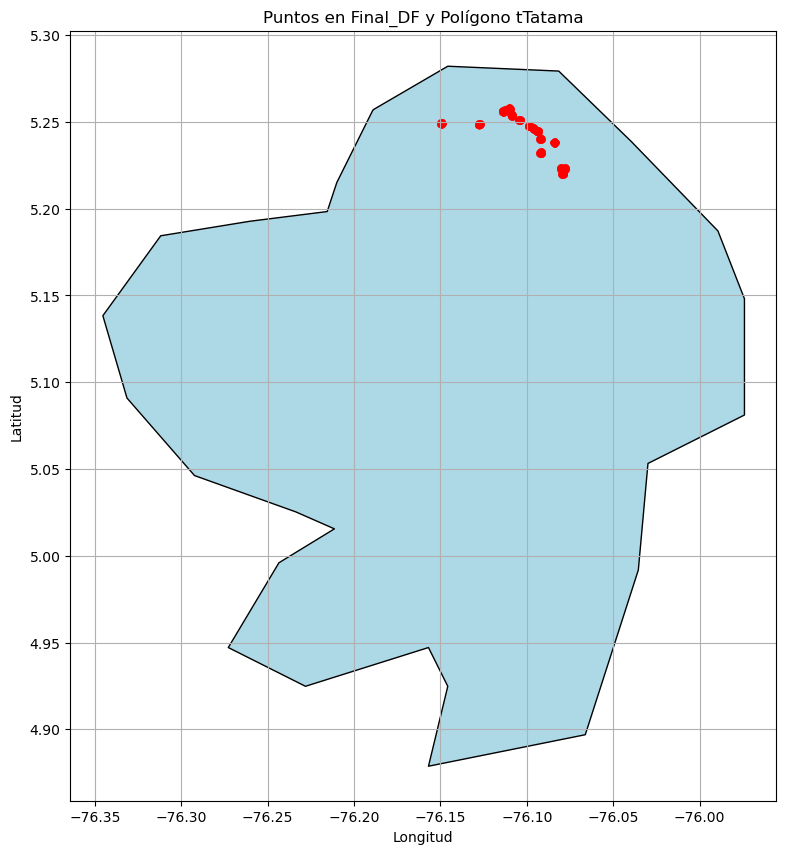

In [217]:
gdf_puntos = gpd.GeoDataFrame(final_df, geometry=gpd.points_from_xy(final_df.Longitud, final_df.Latitud))

# Establecer el CRS (Sistema de Referencia de Coordenadas) para el GeoDataFrame de puntos
# Suponiendo que tu shapefile y tus puntos deben estar en el mismo CRS, por ejemplo, WGS84 (EPSG:4326)
gdf_puntos.crs = gdf_poligono.crs

# Iniciar la visualización
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar el polígono
gdf_poligono.plot(ax=ax, color='lightblue', edgecolor='black')

# Dibujar los puntos
gdf_puntos.plot(ax=ax, color='red', markersize=5)

# Opciones adicionales para mejorar la visualización
ax.set_title('Puntos en Final_DF y Polígono tTatama')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True)

# Mostrar el gráfico
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16784\903592433.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_puntos['geometry'] = gdf_puntos['geometry'].buffer(buffer_in_degrees)


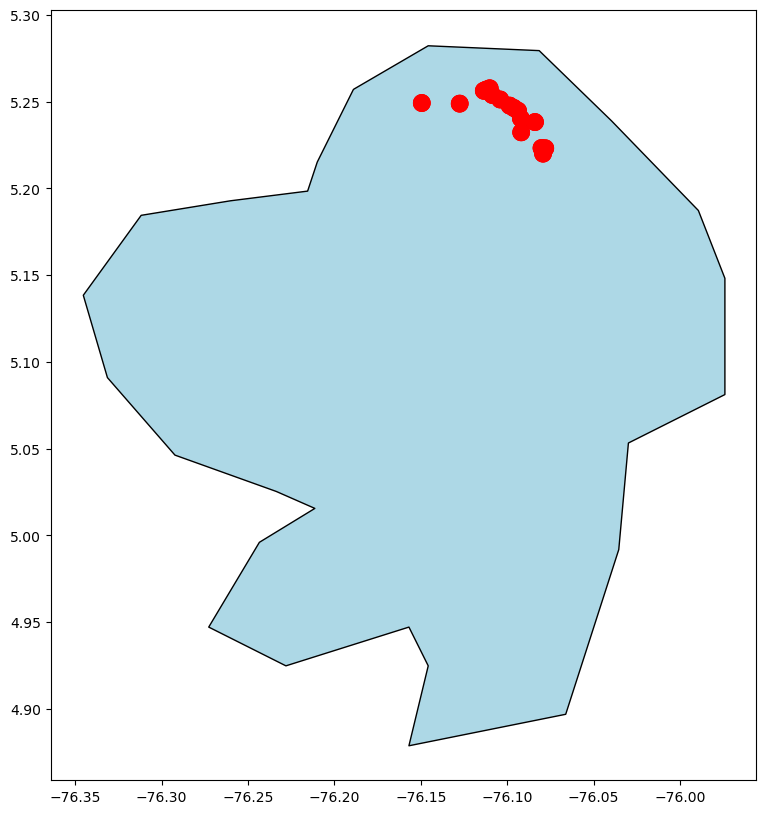

In [218]:
from shapely.geometry import Point

# La resolución de un píxel en grados
pixel_size = 0.00025

# Calculamos la distancia de buffer en grados para 10 píxeles
buffer_in_degrees = 15 * pixel_size

# Ahora aplicamos el buffer
gdf_puntos['geometry'] = gdf_puntos['geometry'].buffer(buffer_in_degrees)

# Si necesitas visualizar los puntos con el buffer en un mapa:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_poligono.plot(ax=ax, color='lightblue', edgecolor='black')  # Polígono de fondo
gdf_puntos.plot(ax=ax, color='red')  # Puntos con buffer
plt.show()

In [195]:
#################################################################################################

In [236]:
df_copy = df.copy()

# Agregamos la columna 'id_iter' que tendrá el nombre de la Estacion para las filas originales
df_copy['id_iter'] = df_copy['Estación']

# Generamos nuevas filas para cada estación con nombres modificados
new_rows = []
for index, row in df_copy.iterrows():
    estacion = row['Estación']
    for i in range(1, 21):
        # Creamos una copia de la fila actual y modificamos 'id_iter'
        new_row = row.copy()
        new_row['id_iter'] = f"{estacion}_{i}"
        new_rows.append(new_row)

# Convertimos la lista de nuevas filas en un DataFrame y lo concatenamos con final_df_copy
new_rows_df = pd.DataFrame(new_rows)
df_extended = pd.concat([df_copy, new_rows_df], ignore_index=True)

# Ahora final_df_extended tiene las filas originales y las nuevas filas con 'id_iter' actualizado
df_extended.head(20)

,Estación,Latitud,Longitud,Elevación,id_iter
0,TA01,5.223194,-76.080167,1400,TA01
1,TA2,5.223056,-76.078000,1600,TA2
2,TA3,5.219972,-76.079278,1500,TA3
3,TA4,5.232250,-76.091917,1400,TA4
4,TA5,5.240222,-76.092083,1500,TA5
5,TA6,5.244694,-76.093750,1600,TA6
6,TA7,5.246250,-76.096111,1700,TA7
7,TA8,5.238167,-76.083944,1300,TA8
8,TA9,5.247639,-76.098611,1800,TA9
9,TA10,5.249139,-76.149444,2000,TA10


In [241]:
desplazamiento = 0.00025 * np.sqrt(20)  # Ejemplo simple para distribuir los 20 puntos

# Calcular nuevas coordenadas solo para los puntos generados
for i, row in df_extended.iterrows():
    if '_' in row['id_iter']:  # Verifica si es un punto generado
        num = int(row['id_iter'].split('_')[-1])  # Obtiene el número del punto generado
        angle = 2 * np.pi * num / 20  # Distribuye los puntos uniformemente en un círculo
        
        # Calcula el desplazamiento en latitud y longitud
        dx = desplazamiento * np.cos(angle)
        dy = desplazamiento * np.sin(angle)
        
        # Actualiza las coordenadas
        df_extended.at[i, 'Latitud'] += dy
        df_extended.at[i, 'Longitud'] += dx

# Mostrar las primeras filas modificadas para verificar
df_extended.head(16)


SyntaxError: unmatched ')' (3645803561.py, line 18)

In [239]:
df_extended.tail(2)


,Estación,Latitud,Longitud,Elevación,id_iter
334,TA16,5.255503,-76.111429,2500,TA16_19
335,TA16,5.256194,-76.111319,2500,TA16_20


In [191]:

#raster_files = [f for f in os.listdir(output_directory) if f.endswith('.tif')]
#station_raster_data = []
#for index, station in df_extended.iterrows():
#    estacion = station['Estación']
#    lat, lon = station['Latitud'], station['Longitud']
    
#    station_data = {'Estacion': estacion, 'Latitud': lat, 'Longitud': lon}
    
#    for raster_filename in raster_files:
#        with rasterio.open(f'{output_directory}/{raster_filename}') as raster:
#            row, col = raster.index(lon, lat)
#            value = raster.read(1)[row, col]  
            
#            if value == raster.nodata:
#                value = float('nan')
            
#            raster_column_name = os.path.splitext(raster_filename)[0]  
#            station_data[raster_column_name] = value

#    station_raster_data.append(station_data)

#final_df = pd.DataFrame(station_raster_data)

In [240]:
raster_files = [f for f in os.listdir(output_directory) if f.endswith('.tif')]

# Preparar una lista para recolectar datos de cada estación y punto generado para cada raster
station_raster_data = []

# Procesar cada estación y punto generado en el DataFrame extendido
for index, station in df_extended.iterrows():
    estacion = station['id_iter']  # Usar 'id_iter' para incluir estaciones y puntos generados
    lat, lon = station['Latitud'], station['Longitud']
    
    # Datos para la estación actual o punto generado
    station_data = {'Estacion': estacion, 'Latitud': lat, 'Longitud': lon}
    
    # Para cada raster, extraer el valor en la coordenada de la estación o punto generado
    for raster_filename in raster_files:
        with rasterio.open(f'{output_directory}/{raster_filename}') as raster:
            # Convierte las coordenadas a índices de píxeles en el raster
            row, col = raster.index(lon, lat)
            
            # Leer el valor del raster en la ubicación
            value = raster.read(1)[row, col]  # Asumimos que la estación/punto está dentro de los límites del raster
            
            # Verifica si el valor es NoData y conviértelo a NaN
            if value == raster.nodata:
                value = float('nan')
            
            # Añade el valor al diccionario de datos
            raster_column_name = os.path.splitext(raster_filename)[0]  # Elimina la extensión .tif para el nombre de la columna
            station_data[raster_column_name] = value

    # Añade los datos de la estación/punto generado a la lista
    station_raster_data.append(station_data)

# Convierte la lista de datos en un DataFrame
final_df_with_raster_data = pd.DataFrame(station_raster_data)

# Mostrar las primeras filas del nuevo DataFrame para verificar
#print(final_df_with_raster_data.head())

  Estacion   Latitud   Longitud  \
0     TA01  5.223194 -76.080167   
1      TA2  5.223056 -76.078000   
2      TA3  5.219972 -76.079278   
3      TA4  5.232250 -76.091917   
4      TA5  5.240222 -76.092083   

   clipped_Hansen_GFC-2022-v1.10_lossyear_10N_080W  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   clipped_Hansen_GFC-2022-v1.10_treecover2000_10N_080W  \
0                                                 45      
1                                                 95      
2                                                 92      
3                                                 95      
4                                                 90      

   resampled_clipped_wc2.1_30s_bio_1  resampled_clipped_wc2.1_30s_bio_10  \
0                          19.033

In [243]:
final_df_with_raster_data.head()

,Estacion,Latitud,Longitud,clipped_Hansen_GFC-2022-v1.10_lossyear_10N_080W,clipped_Hansen_GFC-2022-v1.10_treecover2000_10N_080W,resampled_clipped_wc2.1_30s_bio_1,resampled_clipped_wc2.1_30s_bio_10,resampled_clipped_wc2.1_30s_bio_11,resampled_clipped_wc2.1_30s_bio_12,resampled_clipped_wc2.1_30s_bio_13,...,resampled_clipped_wc2.1_30s_bio_19,resampled_clipped_wc2.1_30s_bio_2,resampled_clipped_wc2.1_30s_bio_3,resampled_clipped_wc2.1_30s_bio_4,resampled_clipped_wc2.1_30s_bio_5,resampled_clipped_wc2.1_30s_bio_6,resampled_clipped_wc2.1_30s_bio_7,resampled_clipped_wc2.1_30s_bio_8,resampled_clipped_wc2.1_30s_bio_9,resampled_clipped_wc2.1_30s_elev
0,TA01,5.223194,-76.080167,0,45,19.033333,19.383333,18.799999,2965.0,416.0,...,970.0,7.816667,90.891479,23.580935,23.299999,14.7,8.599999,18.799999,18.983334,1493
1,TA2,5.223056,-76.078000,0,95,19.033333,19.383333,18.799999,2965.0,416.0,...,970.0,7.816667,90.891479,23.580935,23.299999,14.7,8.599999,18.799999,18.983334,1493
2,TA3,5.219972,-76.079278,0,92,19.033333,19.383333,18.799999,2965.0,416.0,...,970.0,7.816667,90.891479,23.580935,23.299999,14.7,8.599999,18.799999,18.983334,1493
3,TA4,5.232250,-76.091917,0,95,18.787500,19.116667,18.549999,2605.0,379.0,...,862.0,7.741667,92.162704,22.373373,22.900000,14.5,8.400000,18.549999,18.900000,1544
4,TA5,5.240222,-76.092083,0,90,18.754168,19.083334,18.500000,3087.0,414.0,...,885.0,7.725000,91.964287,23.204458,22.900000,14.5,8.400000,18.500000,18.666666,1568


In [244]:
final_df_with_raster_data.tail()

,Estacion,Latitud,Longitud,clipped_Hansen_GFC-2022-v1.10_lossyear_10N_080W,clipped_Hansen_GFC-2022-v1.10_treecover2000_10N_080W,resampled_clipped_wc2.1_30s_bio_1,resampled_clipped_wc2.1_30s_bio_10,resampled_clipped_wc2.1_30s_bio_11,resampled_clipped_wc2.1_30s_bio_12,resampled_clipped_wc2.1_30s_bio_13,...,resampled_clipped_wc2.1_30s_bio_19,resampled_clipped_wc2.1_30s_bio_2,resampled_clipped_wc2.1_30s_bio_3,resampled_clipped_wc2.1_30s_bio_4,resampled_clipped_wc2.1_30s_bio_5,resampled_clipped_wc2.1_30s_bio_6,resampled_clipped_wc2.1_30s_bio_7,resampled_clipped_wc2.1_30s_bio_8,resampled_clipped_wc2.1_30s_bio_9,resampled_clipped_wc2.1_30s_elev
331,TA16_16,5.254068,-76.112865,0,79,14.575,14.75,14.333333,1992.0,260.0,...,667.0,7.216667,90.208321,19.128756,18.700001,10.7,8.000001,14.333333,14.666666,2360
332,TA16_17,5.254385,-76.112241,0,98,14.575,14.75,14.333333,1992.0,260.0,...,667.0,7.216667,90.208321,19.128756,18.700001,10.7,8.000001,14.333333,14.666666,2360
333,TA16_18,5.254880,-76.111747,0,95,14.575,14.75,14.333333,1992.0,260.0,...,667.0,7.216667,90.208321,19.128756,18.700001,10.7,8.000001,14.333333,14.666666,2360
334,TA16_19,5.255503,-76.111429,0,88,14.575,14.75,14.333333,1992.0,260.0,...,667.0,7.216667,90.208321,19.128756,18.700001,10.7,8.000001,14.333333,14.666666,2360
335,TA16_20,5.256194,-76.111319,0,80,14.575,14.75,14.333333,1992.0,260.0,...,667.0,7.216667,90.208321,19.128756,18.700001,10.7,8.000001,14.333333,14.666666,2360


In [246]:
output_csv_path = 'final_df_raster_data.csv'
final_df_with_raster_data.to_csv(output_csv_path, index=False)